### Setup Code Environment

In [1]:
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
%matplotlib inline

### Initialize service code data structures
- Service code / service name map
- Service code histogram

In [2]:
h_file = open("./serviceCodesCount.tsv","r")

code_name_map = {}
code_histogram = {}
                    
patternobj = re.compile('^([0-9a-z]+)\s\|\s([0-9a-z\s]+)$')

for fields in csv.reader(h_file, delimiter="\t"):
    matchobj = patternobj.match(fields[0])
    
    cur_code = matchobj.group(1)
    code_name_map[cur_code] = matchobj.group(2)
    code_histogram[cur_code] = float(fields[1])
    
h_file.close()

### Cluster service code names
- Compute Term Frequency Inverse Document Frequency (TF-IDF) feature vectors
- Apply the K-means algorithm to cluster service code names based on their TF-IDF feature vector
- References:
  - Rose, B. ["Document Clustering in Python"](http://brandonrose.org/clustering)
  - [Text pre-processing to reduce dictionary size](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)

In [12]:
from nltk.stem.snowball import SnowballStemmer

def tokenize(text):
    """ Extracts unigrams (i.e. words) from a string that contains
    a service code name.
    
    Args:
        text: String that stores a service code name
    
    Returns:
        filtered_tokens: List of words contained in a service code name"""
    tokens = [word.lower() for word in nltk.word_tokenize(text)]

    filtered_tokens =\
        filter(lambda elem: re.match('^[a-z]+$', elem) != None,
               tokens)
        
    filtered_tokens =\
        map(lambda elem: re.sub("\s+"," ", elem),
            filtered_tokens)

    return filtered_tokens

def tokenize_and_stem(text):
    """ Applies the Snowball stemmer to unigrams (i.e. words) extracted
    from a string that contains a service code name.
    
    Args:
        text: String that stores a service code name
    
    Returns:
        filtered_tokens: List of words contained in a service code name"""
    stemmer = SnowballStemmer('english')

    tokens = [word.lower() for word in nltk.word_tokenize(text)]

    filtered_tokens =\
        filter(lambda elem: re.match('^[a-z]+$', elem) != None,
               tokens)

    filtered_tokens =\
        map(lambda elem: re.sub("\s+"," ", elem),
            filtered_tokens)

    filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]

    return filtered_tokens

def compute_tfidf_features(code_name_map,
                           tokenizer,
                           params):
    """ Constructs a Term Frequency Inverse Document Frequency (TF-IDF)
    matrix for the Cincinnati 311 service code names.
    
    Args:
        code_name_map: Dictionary that stores the mapping of service
                       codes to service names
        
        tokenizer: Function that transforms a string into a list of
                   words
                   
        params: Dictionary that stores parameters that configure the
                TfidfVectorizer class constructor
                
                - mindocumentcount: Minimum number of term occurrences
                in separate service code names
                
                - maxdocumentfrequency: Maximum document frequency
    
    Returns:
        Tuple that stores a TF-IDF matrix and a TfidfVectorizer class
        object.
        
        Index:   Description:
        -----    -----------
          0      TF-IDF matrix
          1      TfidfVectorizer class object"""
    token_count = 0
    for key in code_name_map.keys():
        token_count += len(tokenize(code_name_map[key]))

    num_codes = len(code_name_map.keys())

    min_df = float(params['mindocumentcount']) / num_codes
    
    tfidf_vectorizer =\
        TfidfVectorizer(max_df=params['maxdocumentfrequency'],
                        min_df=min_df,
                        stop_words = 'english',
                        max_features = token_count,
                        use_idf=True,
                        tokenizer=tokenizer,
                        ngram_range=(1,1))

    tfidf_matrix =\
        tfidf_vectorizer.fit_transform(code_name_map.values())

    return (tfidf_matrix,
            tfidf_vectorizer)

def cluster_311_services(tfidf_matrix,
                         num_clusters,
                         random_seed):
    """Applies the K-means algorithm to cluster Cincinnati 311 service
    codes based on their service name Term Frequency Inverse Document
    Frequency (TF-IDF) feature vector.
    
    Args:
        tfidf_matrix: Cincinnati 311 service names TF-IDF feature matrix
        
        num_clusters: K-means algorithm number of clusters input
        
        random_seed: K-means algorithm random seed input:
    
    Returns:
        clusterid_code_map: Dictionary that stores the mapping of
                            cluster identifier to Cincinnati 311
                            service code

        clusterid_name_map: Dictionary that stores the mapping of
                            cluster identifier to Cincinnati 311
                            service name"""
    km = KMeans(n_clusters = num_clusters,
                random_state=np.random.RandomState(seed=random_seed))

    km.fit(tfidf_matrix)

    clusters = km.labels_.tolist()

    clusterid_code_map = defaultdict(list)
    clusterid_name_map = defaultdict(list)

    codes = code_name_map.keys()
    names = code_name_map.values()

    for idx in range(0, len(codes)):
        clusterid_code_map[clusters[idx]].append(codes[idx])
        clusterid_name_map[clusters[idx]].append(names[idx])
        
    return (clusterid_code_map,
            clusterid_name_map)

def compute_clusterid_totalcounts(clusterid_code_map,
                                  code_histogram):

    clusterid_total_count = defaultdict(int)
    
    num_clusters = len(clusterid_code_map.keys())

    for cur_cluster_id in range(0, num_clusters):
        for cur_code in clusterid_code_map[cur_cluster_id]:
            clusterid_total_count[cur_cluster_id] +=\
                code_histogram[cur_code]
    
    return clusterid_total_count

def print_cluster_stats(clusterid_name_map,
                        clusterid_total_count):

    num_clusters = len(clusterid_total_count.keys())

    for cur_cluster_id in range(0, num_clusters):

        print "clusterid %d | # of codes: %d | total count: %d" %\
            (cur_cluster_id,
            len(clusterid_name_map[cur_cluster_id]),
            clusterid_total_count[cur_cluster_id])

def eval_maxcount_clusterid(clusterid_code_map,
                            clusterid_total_count,
                            code_histogram):

    maxcount_clusterid = np.argmax(clusterid_total_count.values())

    cluster_code_counts =\
        np.zeros(len(clusterid_code_map[maxcount_clusterid]))

    for idx in range(0, len(cluster_code_counts)):
        key = clusterid_code_map[maxcount_clusterid][idx]
        cluster_code_counts[idx] = code_histogram[key]

    plt.bar(range(0,len(cluster_code_counts)),cluster_code_counts)
    plt.grid(True)
    plt.xlabel('Service Code #')
    plt.ylabel('Service Code Count')
    plt.title('Cluster #%d Service Code Histogram' %\
              (maxcount_clusterid))

    max_idx = np.argmax(cluster_code_counts)
    print "max count code: %s" %\
        (clusterid_code_map[maxcount_clusterid][max_idx])

### Apply a word tokenizer to the service code names and construct the TF-IDF feature matrix

In [4]:
params = {'maxdocumentfrequency': 0.25,
          'mindocumentcount': 10}

(tfidf_matrix,
 tfidf_vectorizer) = compute_tfidf_features(code_name_map,
                                            tokenize,
                                            params)

print "# of terms: %d" % (tfidf_matrix.shape[1])
print tfidf_vectorizer.get_feature_names()

# of terms: 31
[u'additnal', u'building', u'cart', u'com', u'complaint', u'compliment', u'damage', u'default', u'dote', u'gallon', u'grassweeds', u'haz', u'ins', u'litter', u'missing', u'new', u'priv', u'prop', u'property', u'recycling', u'repair', u'req', u'request', u'res', u'row', u'service', u'sign', u'street', u'tall', u'trash', u'tree']


### Apply the [K-means algorithm](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to cluster the Cincinnati 311 service codes based on their TF-IDF feature vector

In [5]:
num_clusters = 20
kmeans_seed = 3806933558

(clusterid_code_map,
 clusterid_name_map) = cluster_311_services(tfidf_matrix,
                                            num_clusters,
                                            kmeans_seed)

clusterid_total_count =\
    compute_clusterid_totalcounts(clusterid_code_map,
                                  code_histogram)
    
print_cluster_stats(clusterid_name_map,
                    clusterid_total_count)

clusterid 0 | # of codes: 28 | total count: 28012
clusterid 1 | # of codes: 187 | total count: 148910
clusterid 2 | # of codes: 14 | total count: 993
clusterid 3 | # of codes: 16 | total count: 6438
clusterid 4 | # of codes: 34 | total count: 30743
clusterid 5 | # of codes: 15 | total count: 3025
clusterid 6 | # of codes: 31 | total count: 7614
clusterid 7 | # of codes: 16 | total count: 7260
clusterid 8 | # of codes: 14 | total count: 30238
clusterid 9 | # of codes: 19 | total count: 14557
clusterid 10 | # of codes: 25 | total count: 32466
clusterid 11 | # of codes: 12 | total count: 2864
clusterid 12 | # of codes: 12 | total count: 10177
clusterid 13 | # of codes: 16 | total count: 2527
clusterid 14 | # of codes: 11 | total count: 5902
clusterid 15 | # of codes: 12 | total count: 426
clusterid 16 | # of codes: 14 | total count: 21972
clusterid 17 | # of codes: 11 | total count: 216
clusterid 18 | # of codes: 11 | total count: 1921
clusterid 19 | # of codes: 14 | total count: 9403


### Plot the service code histogram for the maximum size cluster

max count code: mtlfrn


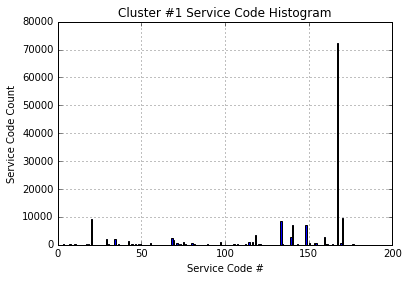

In [6]:
eval_maxcount_clusterid(clusterid_code_map,
                        clusterid_total_count,
                        code_histogram)

In [7]:
params = {'maxdocumentfrequency': 0.25,
          'mindocumentcount': 10}

(tfidf_matrix,
 tfidf_vectorizer) = compute_tfidf_features(code_name_map,
                                            tokenize_and_stem,
                                            params)

print "# of terms: %d" % (tfidf_matrix.shape[1])
print tfidf_vectorizer.get_feature_names()

# of terms: 33
[u'additn', u'build', u'cart', u'collect', u'com', u'complaint', u'compliment', u'damag', u'default', u'dote', u'gallon', u'grasswe', u'haz', u'inspect', u'litter', u'miss', u'new', u'park', u'priv', u'prop', u'properti', u'recycl', u'repair', u'req', u'request', u'res', u'row', u'servic', u'sign', u'street', u'tall', u'trash', u'tree']


In [65]:
num_clusters = 20
kmeans_seed = 3806933558

(clusterid_code_map,
 clusterid_name_map) = cluster_311_services(tfidf_matrix,
                                            num_clusters,
                                            kmeans_seed)

clusterid_total_count =\
    compute_clusterid_totalcounts(clusterid_code_map,
                                  code_histogram)
    
print_cluster_stats(clusterid_name_map,
                    clusterid_total_count)

clusterid 0 | # of codes: 16 | total count: 7260
clusterid 1 | # of codes: 163 | total count: 125123
clusterid 2 | # of codes: 40 | total count: 25091
clusterid 3 | # of codes: 14 | total count: 718
clusterid 4 | # of codes: 37 | total count: 32299
clusterid 5 | # of codes: 34 | total count: 29379
clusterid 6 | # of codes: 22 | total count: 25306
clusterid 7 | # of codes: 16 | total count: 6438
clusterid 8 | # of codes: 18 | total count: 13252
clusterid 9 | # of codes: 13 | total count: 11748
clusterid 10 | # of codes: 11 | total count: 216
clusterid 11 | # of codes: 10 | total count: 1091
clusterid 12 | # of codes: 18 | total count: 3053
clusterid 13 | # of codes: 13 | total count: 982
clusterid 14 | # of codes: 12 | total count: 5913
clusterid 15 | # of codes: 10 | total count: 9446
clusterid 16 | # of codes: 15 | total count: 32572
clusterid 17 | # of codes: 17 | total count: 14571
clusterid 18 | # of codes: 19 | total count: 17540
clusterid 19 | # of codes: 14 | total count: 3666


max count code: mtlfrn


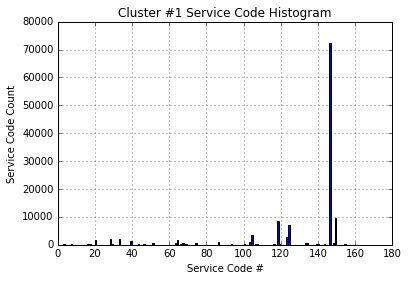

In [66]:
eval_maxcount_clusterid(clusterid_code_map,
                        clusterid_total_count,
                        code_histogram)

In [67]:
maxcount_clusterid = np.argmax(clusterid_total_count.values())

mtlfrn_code = "mtlfrn"

mtlfrn_idx =\
    np.argwhere(np.array(clusterid_code_map[maxcount_clusterid]) ==\
                mtlfrn_code)[0][0]
    
mtlfrn_name = clusterid_name_map[maxcount_clusterid][mtlfrn_idx]

next_clusterid = (clusterid_code_map.keys()[-1])+1

clusterid_code_map[maxcount_clusterid] =\
    filter(lambda elem: elem != mtlfrn_code,
           clusterid_code_map[maxcount_clusterid])
    
clusterid_name_map[maxcount_clusterid] =\
    filter(lambda elem: elem != mtlfrn_name,
           clusterid_code_map[maxcount_clusterid])
    
clusterid_code_map[next_clusterid] = [mtlfrn_code]
clusterid_name_map[next_clusterid] = [mtlfrn_name]

In [68]:
clusterid_total_count =\
    compute_clusterid_totalcounts(clusterid_code_map,
                                  code_histogram)
    
print_cluster_stats(clusterid_name_map,
                    clusterid_total_count)

clusterid 0 | # of codes: 16 | total count: 7260
clusterid 1 | # of codes: 162 | total count: 52932
clusterid 2 | # of codes: 40 | total count: 25091
clusterid 3 | # of codes: 14 | total count: 718
clusterid 4 | # of codes: 37 | total count: 32299
clusterid 5 | # of codes: 34 | total count: 29379
clusterid 6 | # of codes: 22 | total count: 25306
clusterid 7 | # of codes: 16 | total count: 6438
clusterid 8 | # of codes: 18 | total count: 13252
clusterid 9 | # of codes: 13 | total count: 11748
clusterid 10 | # of codes: 11 | total count: 216
clusterid 11 | # of codes: 10 | total count: 1091
clusterid 12 | # of codes: 18 | total count: 3053
clusterid 13 | # of codes: 13 | total count: 982
clusterid 14 | # of codes: 12 | total count: 5913
clusterid 15 | # of codes: 10 | total count: 9446
clusterid 16 | # of codes: 15 | total count: 32572
clusterid 17 | # of codes: 17 | total count: 14571
clusterid 18 | # of codes: 19 | total count: 17540
clusterid 19 | # of codes: 14 | total count: 3666
cl